In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# To do this for a shared folder you need to add the GeoCompassSegmentations folder as a shortcut in MyDrive
GOOGLE_DRIVE_FOLDER = '/content/drive/MyDrive/GeoCompassSegmentations'

920


In [3]:
# Install Dependencies
!pip install rasterio
!git clone https://github.com/facebookresearch/sam2.git
%cd ./sam2
!pip install -e .
# Install dependencies

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.43 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.8 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=e8ba67281fa553bd400228edadc65902a9117a147e56f4082167ce10fc468c79
  Stored in directory: /tmp/pip-ephem-wheel-cache-r7numt9j/wheels/9e/fa

In [4]:
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
import re
import torch
from pathlib import Path

In [5]:
# Unzip images into local machine (content directory)

!rm -rf '/content/data'
!mkdir '/content/data'
!cp "/content/drive/MyDrive/GeoCompassSegmentations/data-96-rgb/tile_index.csv" '/content/data/tile_index.csv'
!unzip -d '/content/data/' "/content/drive/MyDrive/GeoCompassSegmentations/data-96-rgb/tiles.zip"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/tiles/tile_label_09341.tif  
  inflating: /content/data/tiles/tile_rgb_01297.png.msk  
 extracting: /content/data/tiles/tile_rgb_04756.png  
  inflating: /content/data/tiles/tile_ms_06563.tif  
 extracting: /content/data/tiles/tile_rgb_09593.png  
  inflating: /content/data/tiles/tile_label_03907.tif  
  inflating: /content/data/tiles/tile_label_08429.tif  
  inflating: /content/data/tiles/tile_rgb_06136.png.msk  
 extracting: /content/data/tiles/tile_rgb_00550.png  
 extracting: /content/data/tiles/tile_rgb_08414.png  
  inflating: /content/data/tiles/tile_label_05415.tif  
  inflating: /content/data/tiles/tile_rgb_06008.png.aux.xml  
  inflating: /content/data/tiles/tile_ms_05878.tif  
  inflating: /content/data/tiles/tile_label_09134.tif  
  inflating: /content/data/tiles/tile_label_07038.tif  
  inflating: /content/data/tiles/tile_rgb_01492.png.msk  
  inflating: /content/data/tiles/tile_rgb_03006.png.msk

In [6]:
!./checkpoints/download_ckpts.sh

--2025-12-09 04:09:35--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.76.47, 65.8.76.89, 65.8.76.77, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.76.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   251MB/s    in 0.6s    

2025-12-09 04:09:35 (251 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-12-09 04:09:35--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.76.47, 65.8.76.89, 65.8.76.77, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.76.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/vnd.snesdev-

In [7]:
# Import tortise data libraries
import sys
sys.path.append(GOOGLE_DRIVE_FOLDER + '/Colab_Notebooks/TORTOISE/src')

In [8]:
from tortoise.dataloader import build_dataloaders

BATCH_SIZE = 16

train_loader, val_loader, test_loader, _ = build_dataloaders(
    "/content/data/tiles",
    '/content/data/tile_index.csv',
    BATCH_SIZE,
    seed = 42,
    train_ratio = 0.8,
    val_ratio = 0.1,
    test_ratio = None,
    use_rgb=  True,
    use_ms=False,
    num_workers = 0,
)


In [9]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = "cuda"
# Initialize sam model
sam2_checkpoint = "sam2.1_hiera_small.pt" # path to model weight
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml" #  model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device) # load model
predictor = SAM2ImagePredictor(sam2_model)

model = predictor.model

In [10]:
RELOAD_EXISTING_MODEL = False
if RELOAD_EXISTING_MODEL:
    path = GOOGLE_DRIVE_FOLDER + f"/Colab_Notebooks/SAM_model_96_px_cp_3.pth"
    model.load_state_dict(torch.load(path, weights_only=True))

**Set the hyperparameters here:**

**Super batches** are the concept of caching image embeddings for each batch onto disk, and then training only a subset of all the batches for a bunch of epochs before caching another set of embeddings to disk and training a second subset of batches. It's supposed to speed things up pretty dramatically if you want to run multiple epochs, since calculating image embeddings takes up about 80% of the training time for SAM2.

In [11]:
#--------------------------------
# HYPERPARAMETERS
#--------------------------------
from torch.optim import AdamW

# Initialize the optimizer and the loss function
# For encoder add: {"params": model.image_encoder.parameters(), "lr": 1e-5, "weight_decay": 1e-4},
optimizer = AdamW([
    {"params": model.sam_mask_decoder.parameters(), "lr": 5e-6, "weight_decay": 1e-4},
]) # mixed precision
scaler = torch.cuda.amp.GradScaler()
# Our loss will not calculate gradients for any data that is labelled 0 (not masked)
pos_weight = 2.78
pos_weight_tensor = torch.Tensor([[[pos_weight]]]).to(device)
bce_loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight_tensor)

TRAIN_ENCODER = False

USE_SUPER_BATCHES = True
NUM_SUPER_BATCHES = 4
epochs = 5

/tmp/ipython-input-2012561541.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [12]:
import shutil
from torch.utils.data import DataLoader
#----------------------------------------
# CACHE EMBEDDINGS / SUPER BATCH CODE
#----------------------------------------
def cache_super_batch(cur_super_batch, num_super_batches, train_loader):
    # Split the FULL list of batch indices into N super-batch groups
    batch_indices = np.array_split(np.arange(len(train_loader)), num_super_batches)
    cur_indices = batch_indices[cur_super_batch]
    print("Caching super batch")
    start_batch, end_batch = cur_indices[0], cur_indices[-1] + 1

    # Wipe old cache
    cache_dir = "/content/embedding_cache"
    shutil.rmtree(cache_dir, ignore_errors=True)
    os.makedirs(cache_dir, exist_ok=True)

    # Create normal dataloader to iterate over dataset
    loader = DataLoader(train_loader.dataset, batch_size=BATCH_SIZE, shuffle=False)

    model.eval()   # encoder only
    predictor.model.to(device)

    print(f"\nCaching super-batch {cur_super_batch+1}/{num_super_batches} "
          f"(batches {start_batch} → {end_batch-1})")

    for batch_idx, batch in enumerate(tqdm(loader, desc="Caching batches", total=len(cur_indices))):
        if batch_idx < start_batch:
            continue
        if batch_idx >= end_batch:
            break

        images = batch['rgb'].to(device)

        img_list = [
            images[i].permute(1,2,0).cpu().numpy().astype(np.uint8)
            for i in range(images.shape[0])
        ]

        # Encoder forward
        predictor.set_image_batch(img_list)
        with torch.no_grad():
            image_embeddings = predictor._features["image_embed"].half().cpu()
            high_res_feats = [h.half().cpu() for h in predictor._features["high_res_feats"]]

        torch.save({
            "image_embeddings": image_embeddings,
            "high_res_feats": high_res_feats,
            "mask": batch["mask"],
            "label": batch["label"]
        }, os.path.join(cache_dir, f"batch_{batch_idx}.pt"))

    return start_batch, end_batch, cache_dir

def cache_val_super_batch():
    val_cache_dir = "/content/val_embedding_cache_fp16"
    shutil.rmtree(val_cache_dir, ignore_errors=True)
    os.makedirs(val_cache_dir, exist_ok=True)

    # Pick 20 batches from your validation dataset
    num_val_batches_to_cache = 20

    model.eval()
    predictor.model.to(device)

    for batch_idx, batch in enumerate(tqdm(val_loader, desc="Precaching validation batches", total=num_val_batches_to_cache)):
        if batch_idx >= num_val_batches_to_cache:
            break

        images = batch['rgb'].to(device)
        img_list = [images[i].permute(1,2,0).cpu().numpy().astype(np.uint8)
                    for i in range(images.shape[0])]

        predictor.set_image_batch(img_list)
        with torch.no_grad():
            image_embeddings = predictor._features["image_embed"].half().cpu()
            high_res_feats = [h.half().cpu() for h in predictor._features["high_res_feats"]]

        torch.save({
            "image_embeddings": image_embeddings,
            "high_res_feats": high_res_feats,
            "mask": batch['mask'],
            "label": batch['label']
        }, os.path.join(val_cache_dir, f"val_batch{batch_idx}.pt"))

        # free predictor memory
        predictor._features = {}
        torch.cuda.empty_cache()

    print(f"Cached {num_val_batches_to_cache} validation batches")

In [13]:
model.sam_mask_decoder.train(True) # enable training of mask decoder
for param in model.sam_mask_decoder.parameters():
    param.requires_grad = True

# I doubt this is worth training. Let's keep it off.
model.sam_prompt_encoder.train(False) # disable training of prompt encoder
for param in model.sam_prompt_encoder.parameters():
    param.requires_grad = False

if TRAIN_ENCODER:
    model.image_encoder.train(True)
    for p in model.image_encoder.parameters():
        p.requires_grad = True
else:
    print("Don't train encoder")
    model.image_encoder.train(False)
    for p in model.image_encoder.parameters():
        p.requires_grad = False

Don't train encoder


In [14]:
from torch.profiler import profile, ProfilerActivity, record_function
point_labels = torch.tensor([[2, 3]], dtype=torch.int32, device=device).repeat(BATCH_SIZE, 1)
def bounding_boxes(mask):
    # mask: (B, H, W)
    # Returns: (B, 4) [ymin, xmin, ymax, xmax]

    B, H, W = mask.shape
    # ymin = 0, xmin = 0, ymax = H, xmax = W
    boxes = torch.tensor([0, 0, H, W], dtype=torch.float32, device=mask.device)
    return boxes.unsqueeze(0).repeat(B, 1)


def forward_pass(batch, predictor):
    high_res_features, image_embeddings, point_inputs = get_model_outputs(batch, predictor)
    with torch.cuda.amp.autocast():
        # Forward steps should be autocast I think
        (
            low_res_multimasks,
            high_res_multimasks,
            ious,
            low_res_masks,
            high_res_masks,
            obj_ptr,
            object_score_logits,
        ) = model._forward_sam_heads(
            backbone_features=image_embeddings,
            point_inputs=point_inputs,
            mask_inputs=None,
            high_res_features=high_res_features,
            multimask_output=False,  # if you want single best mask; True gives 3 candidates
        )
    loss, iou = get_loss_from_model_output(batch, high_res_masks)
    return loss, iou

def get_model_outputs(batch, predictor):
    # If you want to train the backbone, you need to use a different function
    # since this one has @torch.no_grad as a decorator
    image = batch.get('rgb').to(device)
    mask = batch.get('mask').to(device)

    imgs = image
    imgs = imgs.cpu().numpy().astype(np.uint8)
    img_list = [np.einsum('ijk->jki',imgs[i]) for i in range(imgs.shape[0])]
    if TRAIN_ENCODER:
        set_image_batch_trainable(predictor, img_list)
    else:
        with torch.profiler.profile(
            activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
            record_shapes=True,
            with_stack=True
        ) as prof:
            predictor.set_image_batch(img_list)
        print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total", row_limit=10))
    # forward pass
    boxes = bounding_boxes(mask)

    unnorm_box = predictor._transforms.transform_boxes(
        boxes, normalize=False, orig_hw=predictor._orig_hw[-1]
    )

    B = unnorm_box.size(0)

    # Convert box to two point corner representation, with labels [2, 3] (int)
    point_coords = unnorm_box.reshape(B, 2, 2)  # (B, 2, 2)
    point_inputs = {"point_coords": point_coords, "point_labels": point_labels}

    # Image embeddings and high-res features are cached in predictor._features by set_image_batch
    image_embeddings = predictor._features["image_embed"]       # shape [B, C, H_emb, W_emb]
    high_res_features = [h for h in predictor._features["high_res_feats"]]  # list of tensors or []
    return high_res_features, image_embeddings, point_inputs

def set_image_batch_trainable(predictor, image_list: list):
    # SAM2ImagePredictor.set_image_batch but with gradients enabled
    with torch.enable_grad():
        predictor.reset_predictor()  # clear previous features

        # Store original image sizes
        predictor._orig_hw = [im.shape[:2] for im in image_list]

        # Transform images: resizing, normalization, batching
        img_batch = predictor._transforms.forward_batch(image_list)
        img_batch = img_batch.to(predictor.device)
        batch_size = img_batch.shape[0]

        assert len(img_batch.shape) == 4 and img_batch.shape[1] == 3, \
            f"img_batch must be of size Bx3xHxW, got {img_batch.shape}"

        # Forward through SAM2 encoder
        backbone_out = predictor.model.forward_image(img_batch)
        _, vision_feats, _, _ = predictor.model._prepare_backbone_features(backbone_out)

        if predictor.model.directly_add_no_mem_embed:
            vision_feats[-1] = vision_feats[-1] + predictor.model.no_mem_embed

        # Reshape features into the format predictor expects
        feats = [
            feat.permute(1, 2, 0).view(batch_size, -1, *feat_size)
            for feat, feat_size in zip(vision_feats[::-1], predictor._bb_feat_sizes[::-1])
        ][::-1]

        # Cache features
        predictor._features = {"image_embed": feats[-1], "high_res_feats": feats[:-1]}
        predictor._is_image_set = True
        predictor._is_batch = True

from tortoise.train import combined_loss, masked_iou, dice_loss

def get_loss_from_model_output(batch, high_res_masks):
    # Ground-truth masks: ensure shape [B, 1, H, W], float tensor
    gt_label = batch.get("label").float().to(device)
    valid_mask = batch.get("mask").float().to(device)
    # high_res_masks has shape [B, 1, H, W] (logits before sigmoid)

    # The logits are going to be much bigger than the gorund truth image (1024x1024 vs 48x48)
    # so we need to downscale them
    pred_logits_downsampled = torch.nn.functional.interpolate(high_res_masks, size=gt_label.shape[-2:], mode='nearest')  # logits

    # Avoid crazy loss values for BCE
    pred_logits = torch.clamp(pred_logits_downsampled, -10.0, 10.0)

    # BCE (masked)
    bce_raw = bce_loss_fn(pred_logits, gt_label)             # shape: (B,1,H,W)
    bce     = (bce_raw * valid_mask).sum() / (valid_mask.sum() + 1e-6)
    # Dice
    d_loss = dice_loss(pred_logits, gt_label, valid_mask)

    loss = 4*bce + d_loss
    iou = masked_iou(pred_logits, gt_label, valid_mask)

    return loss, iou

# For super batching
def train_one_epoch_from_cache(cache_dir, start_batch, end_batch):
    losses = []
    ious = []
    epoch_losses = []
    cache_files = [f"batch_{i}.pt" for i in range(start_batch, end_batch)]
    for fname in cache_files:
        data = torch.load(os.path.join(cache_dir, fname))

        image_embeddings = data["image_embeddings"].to(device)
        high_res_feats = [h.to(device) for h in data["high_res_feats"]]
        masks = data["mask"].to(device)
        labels = data["label"].to(device)

        boxes = bounding_boxes(masks)
        _, _, _, unnorm_box = predictor._prep_prompts(
            point_coords=None,
            point_labels=None,
            box=boxes,
            mask_logits=None,
            normalize_coords=False
        )

        point_coords = unnorm_box.reshape(len(masks), 2, 2)
        point_labels = torch.tensor([[2, 3]], dtype=torch.int32, device=device)\
                             .repeat(len(masks), 1)

        point_inputs = {
            "point_coords": point_coords,
            "point_labels": point_labels
        }

        # Decoder forward
        with torch.cuda.amp.autocast():
            _, high_res_multimasks, *_ = model._forward_sam_heads(
                backbone_features=image_embeddings,
                point_inputs=point_inputs,
                mask_inputs=None,
                high_res_features=high_res_feats,
                multimask_output=False,
            )

        # Loss + step
        loss, iou = get_loss_from_model_output(
            {"mask": masks, "label": labels},
            high_res_multimasks
        )
        losses.append(loss.item())
        ious.append(iou.item())

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    avg_loss = mean(losses)
    avg_iou = mean(ious)
    print(f"After Epoch {epoch} - IOU: {avg_iou},    Loss: {avg_loss}")
    return avg_loss, avg_iou

def val_from_cache(super_idx):
    val_cache_dir = "/content/val_embedding_cache_fp16"
    val_cache_files = sorted(os.listdir(val_cache_dir))
    model.eval()
    losses = []
    ious = []
    with torch.no_grad():
        for val_file in tqdm(val_cache_files, desc="Evaluating val batches"):
            data = torch.load(os.path.join(val_cache_dir, val_file))
            image_embeddings = data['image_embeddings'].to(device)
            high_res_feats = [h.to(device) for h in data['high_res_feats']]
            masks = data['mask'].to(device)
            labels = data['label'].to(device)

            # Compute prompts (if needed)
            boxes = bounding_boxes(masks)
            mask_input, unnorm_coords, labels_out, unnorm_box = predictor._prep_prompts(
                point_coords=None,
                point_labels=None,
                box=boxes,
                mask_logits=None,
                normalize_coords=False
            )
            point_coords = unnorm_box.reshape(len(masks), 2, 2)
            point_labels = torch.tensor([[2, 3]], dtype=torch.int32, device=device).repeat(len(masks), 1)
            point_inputs = {"point_coords": point_coords, "point_labels": point_labels}

            # Forward through decoder
            with torch.cuda.amp.autocast():
                low_res_multimasks, high_res_multimasks, *_ = model._forward_sam_heads(
                    backbone_features=image_embeddings,
                    point_inputs=point_inputs,
                    mask_inputs=None,
                    high_res_features=high_res_feats,
                    multimask_output=False
                )

            loss, iou = get_loss_from_model_output({"mask": masks, "label": labels}, high_res_multimasks)
            losses.append(loss.item())
            ious.append(iou.item())
    avg_loss = mean(losses)
    avg_iou = mean(ious)
    print(f"Average validation loss for superbatch {super_idx}: {avg_loss}, Average IOU: {avg_iou}")
    return avg_loss, avg_iou


In [15]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import time
#Training loop
num_epochs = epochs # TODO: Remove this
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
validation_ious = []
validation_losses = []
training_ious = []
training_losses = []
if USE_SUPER_BATCHES:
    start_time = time.time()
    cache_val_super_batch()
    for super_idx in range(NUM_SUPER_BATCHES):
        start_batch, end_batch, cache_dir = cache_super_batch(
            super_idx, NUM_SUPER_BATCHES, train_loader
        )
        print(f"🐢 Training batch {super_idx}!")
        model.train()
        for epoch in range(num_epochs):
            print(f"Starting epoch {epoch}")
            training_loss, training_iou = train_one_epoch_from_cache(cache_dir, start_batch, end_batch)
            training_losses.append(training_loss)
            training_ious.append(training_iou)
            elapsed_seconds = time.time() - start_time
            print(f"Total Time Elapsed: {int(elapsed_seconds / 3600)}:{int(elapsed_seconds / 60)%60}:{int(elapsed_seconds)%60}")
            val_loss, val_iou = val_from_cache(super_idx)
            validation_losses.append(val_loss)
            validation_ious.append(val_iou)
        # Save the model's state dictionary to a file each super batch
        torch.save(model.state_dict(), GOOGLE_DRIVE_FOLDER + f"/Colab_Notebooks/SAM_model_96_px_pt_2_cp_{super_idx}.pth")

else:
    # Traditional training.
    for epoch in range(num_epochs):
        epoch_losses = []
        batches = tqdm(train_loader)
        print(f"Starting Epoch {epoch}")
        for batch_num, batch in enumerate(batches):
            loss, iou = forward_pass(batch, predictor)

            # backward pass
            optimizer.zero_grad(set_to_none=True) # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update()

            if(batch_num%200 == 0):
                print(f"IOU at batch {batch_num}: {iou},    Loss: {loss.item()}")

        model.eval()
        with torch.no_grad():
            print("Running Validation")
            val_ious = []
            for i,val_batch in enumerate(val_loader):
                loss, iou = forward_pass(val_batch, predictor)
                val_ious.append(iou)
                if i % 20 == 19:
                    break
            print(f"Batch number: {batch_num}, Validation Loss: {mean(val_ious)}")
        model.train()
        epoch_losses.append(loss.item())
        print(f'EPOCH: {epoch}')
        print(f"Loss: {loss}")
        print(f'Mean loss: {mean(epoch_losses)}')




Precaching validation batches: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Cached 20 validation batches
Caching super batch

Caching super-batch 1/4 (batches 0 → 383)


Caching batches: 100%|██████████| 384/384 [05:28<00:00,  1.17it/s]


🐢 Training batch 0!
Starting epoch 0


/tmp/ipython-input-2943760098.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


After Epoch 0 - IOU: 0.28502247726517754,    Loss: 65.05939608936508
Total Time Elapsed: 0:9:2


Evaluating val batches:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2943760098.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating val batches: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Average validation loss for superbatch 0: 92.95161018371581, Average IOU: 0.3132309440523386
Starting epoch 1
After Epoch 1 - IOU: 0.5550771216415645,    Loss: 34.902155574411154
Total Time Elapsed: 0:12:28


Evaluating val batches: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Average validation loss for superbatch 0: 24.543474817276, Average IOU: 0.59689332395792
Starting epoch 2
After Epoch 2 - IOU: 0.5989753193862271,    Loss: 27.430898558348417
Total Time Elapsed: 0:15:54


Evaluating val batches: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Average validation loss for superbatch 0: 23.318059492111207, Average IOU: 0.6098983764648438
Starting epoch 3
After Epoch 3 - IOU: 0.6094946795880484,    Loss: 26.100329402834177
Total Time Elapsed: 0:19:25


Evaluating val batches: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Average validation loss for superbatch 0: 22.649124813079833, Average IOU: 0.6161612048745155
Starting epoch 4
After Epoch 4 - IOU: 0.6159409874332292,    Loss: 25.27348888417085
Total Time Elapsed: 0:23:22


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Average validation loss for superbatch 0: 22.24430208206177, Average IOU: 0.6187273219227791
Caching super batch

Caching super-batch 2/4 (batches 384 → 767)


Caching batches: 768it [06:31,  1.96it/s]


🐢 Training batch 1!
Starting epoch 0
After Epoch 0 - IOU: 0.5765131284521582,    Loss: 26.592767012615997
Total Time Elapsed: 0:33:25


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Average validation loss for superbatch 1: 25.919330978393553, Average IOU: 0.5878142818808556
Starting epoch 1
After Epoch 1 - IOU: 0.5943253575630175,    Loss: 23.65388344724973
Total Time Elapsed: 0:36:54


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Average validation loss for superbatch 1: 23.349767017364503, Average IOU: 0.5953926384449005
Starting epoch 2
After Epoch 2 - IOU: 0.6061963046862123,    Loss: 21.996457705895107
Total Time Elapsed: 0:40:25


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Average validation loss for superbatch 1: 22.297712087631226, Average IOU: 0.6113852530717849
Starting epoch 3
After Epoch 3 - IOU: 0.6118804656240778,    Loss: 21.287395175546408
Total Time Elapsed: 0:43:56


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Average validation loss for superbatch 1: 21.85958847999573, Average IOU: 0.618532831966877
Starting epoch 4
After Epoch 4 - IOU: 0.6152505231051085,    Loss: 20.82688958446185
Total Time Elapsed: 0:47:26


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Average validation loss for superbatch 1: 21.714079189300538, Average IOU: 0.6206924125552178
Caching super batch

Caching super-batch 3/4 (batches 768 → 1150)


Caching batches: 1151it [07:28,  2.56it/s]


🐢 Training batch 2!
Starting epoch 0
After Epoch 0 - IOU: 0.6251532640454041,    Loss: 24.029698864909438
Total Time Elapsed: 0:58:28


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Average validation loss for superbatch 2: 21.993570041656493, Average IOU: 0.6389799043536186
Starting epoch 1
After Epoch 1 - IOU: 0.6339205748185165,    Loss: 23.062728260578126
Total Time Elapsed: 1:2:0


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Average validation loss for superbatch 2: 21.162562322616576, Average IOU: 0.6293975591659546
Starting epoch 2
After Epoch 2 - IOU: 0.6392433070249408,    Loss: 22.148077473627993
Total Time Elapsed: 1:5:30


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Average validation loss for superbatch 2: 21.053628349304198, Average IOU: 0.6294385582208634
Starting epoch 3
After Epoch 3 - IOU: 0.642730806304954,    Loss: 21.671785508994958
Total Time Elapsed: 1:9:1


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Average validation loss for superbatch 2: 20.818520164489748, Average IOU: 0.6311071246862412
Starting epoch 4
After Epoch 4 - IOU: 0.6456954653129254,    Loss: 21.27161733537679
Total Time Elapsed: 1:12:33


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Average validation loss for superbatch 2: 20.632461833953858, Average IOU: 0.6327097460627555
Caching super batch

Caching super-batch 4/4 (batches 1151 → 1533)


Caching batches: 1534it [08:26,  3.03it/s]


🐢 Training batch 3!
Starting epoch 0
After Epoch 0 - IOU: 0.6194401669595848,    Loss: 23.690825317920655
Total Time Elapsed: 1:24:35


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Average validation loss for superbatch 3: 21.224118566513063, Average IOU: 0.655118203163147
Starting epoch 1
After Epoch 1 - IOU: 0.6302196131221107,    Loss: 22.143270755872404
Total Time Elapsed: 1:28:21


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Average validation loss for superbatch 3: 20.947981977462767, Average IOU: 0.6505523949861527
Starting epoch 2
After Epoch 2 - IOU: 0.6372711847991881,    Loss: 20.964476586010687
Total Time Elapsed: 1:32:10


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Average validation loss for superbatch 3: 20.6674156665802, Average IOU: 0.6509726017713546
Starting epoch 3
After Epoch 3 - IOU: 0.6412990594186817,    Loss: 20.438839749318813
Total Time Elapsed: 1:35:58


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Average validation loss for superbatch 3: 20.57694983482361, Average IOU: 0.6521651268005371
Starting epoch 4
After Epoch 4 - IOU: 0.6443025277808883,    Loss: 20.071172032592813
Total Time Elapsed: 1:39:44


Evaluating val batches: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Average validation loss for superbatch 3: 20.637855100631715, Average IOU: 0.6528103709220886


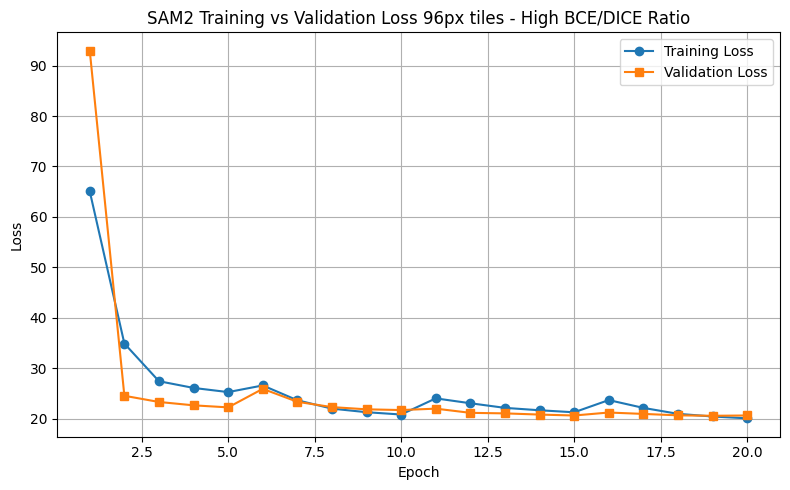

In [16]:
epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, training_losses, label="Training Loss", marker='o')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAM2 Training vs Validation Loss 96px tiles - High BCE/DICE Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

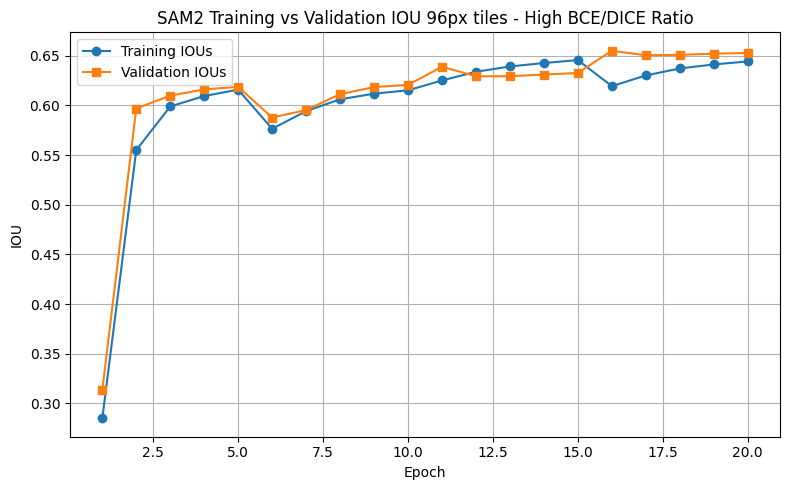

In [17]:
epochs = range(1, len(training_ious) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, training_ious, label="Training IOUs", marker='o')
plt.plot(epochs, validation_ious, label="Validation IOUs", marker='s')

plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.title("SAM2 Training vs Validation IOU 96px tiles - High BCE/DICE Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# import gc
# del predictor
# gc.collect()
# torch.cuda.empty_cache()

In [18]:
# To shut down colab after the run import the following lines.
from google.colab import runtime
runtime.unassign()